# Recap from our last churn prediction code

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [105]:
df = pd.read_csv('Telcos_Cus_Churn.csv')
 
df.columns = df.columns.str.lower().str.replace(' ', '_')
 
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
 
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
 
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)
 
df.churn = (df.churn == 'yes').astype(int)

In [106]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
 
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values
 
del df_train['churn']
del df_val['churn']
del df_test['churn'] 

In [107]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
 
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [108]:
dv = DictVectorizer(sparse=False)
 
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
 
model = LogisticRegression()
model.fit(X_train, y_train)

/Users/olaoluwatunmise/miniconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [109]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
 
y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()
 
# Output: 0.8034066713981547

0.8019872249822569

# Accuracy and Dummy Model

In [110]:
len(y_val)

1409

In [111]:
(y_val == churn_decision).mean()

0.8019872249822569

In [112]:
1132/1409

0.8034066713981547

In [113]:
from sklearn.metrics import accuracy_score

In [114]:
accuracy_score(y_val, y_pred >= 0.5)

0.8019872249822569

In [115]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' %(t, score))
    scores.append(score)

0.00 0.274
0.05 0.505
0.10 0.591
0.15 0.665
0.20 0.709
0.25 0.740
0.30 0.762
0.35 0.770
0.40 0.786
0.45 0.793
0.50 0.802
0.55 0.801
0.60 0.796
0.65 0.784
0.70 0.764
0.75 0.744
0.80 0.732
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


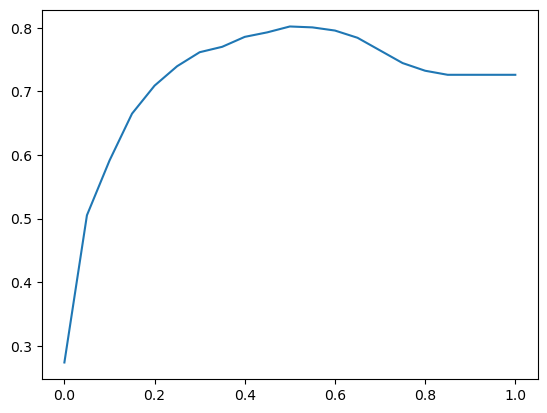

In [116]:
plt.plot(thresholds, scores)

In [117]:
from collections import Counter

In [118]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [119]:
1 - y_val.mean()

0.7260468417317246

# Confusion Table

In [120]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [121]:

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)


In [122]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [123]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [124]:
confustion_matrix = np.array([
        [tn, fp],
        [fn, tp]

])
confustion_matrix

array([[920, 103],
       [176, 210]])

In [126]:
(confustion_matrix / confustion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

# Precision and Recall

In [128]:
(tp + tn) / (tp + tn +fp + fn)

0.8019872249822569

In [129]:
p = tp / (tp + fp)
p

0.670926517571885

In [130]:
tp

210

In [131]:
tp + fp

313

In [132]:
r = tp / (tp + fn)
r

0.5440414507772021

In [133]:
tp + fn

386